# To-do 
1. implement Boltzmann reweighting so expectation is properly calculated 
2. implement training by energy and KL loss (see description of training schedule below as well as section "Adaptive sampling and training" from Noe et al.) 
3. (quick and easy) generalize energy functions (they need to expect PyTorch tensors instead of numpy arrays). So for example every `np.sum()` should be `torch.sum()`, etc. 
3. Why does line 40 of `net.py` have a negative sign when calculating the Jacobian? It's right (otherwise RealNVP won't work) but I don't understand it. 

# Setup

In [51]:
import os
import sys
sys.path.insert(0, os.path.join(os.getcwd(), ".."))

import torch
from torch import distributions
from torch import nn
from sklearn import datasets

import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline
%load_ext autoreload
%autoreload 2 # Reload all modules every time before executing the Python code typed.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
from project.models.ising import IsingModel
import project.networks.net as net

# Define Ising Model

CPU times: user 293 µs, sys: 0 ns, total: 293 µs
Wall time: 297 µs


tensor(9.6000)

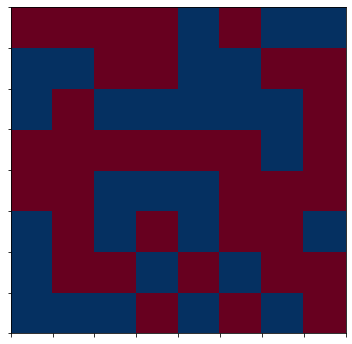

In [53]:
h = 0.0
J = 0.8
T = 1.0
N = 8

ising = IsingModel(h = h, J = J)
x0 = ising.init_coords(N)

ising.draw_config(x0)
%time ising.energy(torch.from_numpy(x0)) # energy of a given configuration 

## Create training set
We'd like to have a $m$ x $N$ matrix containing our training data where $m$ is the number of realizations of the system and $N$ is the number of features (i.e. the flattened dimensions of the system). For example, a training set with 1000 samples of the Ising Model for $N=8$ would be of size (1000, 64). 

In [54]:
num_samples = 100 # Use 1000 at run-time as done in Noe et al. for the biwell potential 
flattened_size = N**2

training_set = np.zeros((num_samples,flattened_size), dtype=np.float32)
for i in range(num_samples):
    training_set[i,:] = ising.init_coords(N).flatten() # generate random configuration 
training_set = torch.from_numpy(training_set) # convert to PyTorch tensor 

As an aside, note that although we flatten our configurations for training, the flattening procedure can easily be reversed via the `rehsape()` function: 

In [55]:
np.array(x0)

array([[-1, -1, -1,  1, -1,  1, -1,  1],
       [-1,  1,  1, -1,  1, -1,  1,  1],
       [-1,  1, -1,  1, -1,  1,  1, -1],
       [ 1,  1, -1, -1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1],
       [-1,  1, -1, -1, -1, -1, -1,  1],
       [-1, -1,  1,  1, -1, -1,  1,  1],
       [ 1,  1,  1,  1, -1,  1, -1, -1]])

In [56]:
np.array(x0).flatten().reshape((N,N))

array([[-1, -1, -1,  1, -1,  1, -1,  1],
       [-1,  1,  1, -1,  1, -1,  1,  1],
       [-1,  1, -1,  1, -1,  1,  1, -1],
       [ 1,  1, -1, -1, -1,  1,  1,  1],
       [ 1,  1,  1,  1,  1,  1, -1,  1],
       [-1,  1, -1, -1, -1, -1, -1,  1],
       [-1, -1,  1,  1, -1, -1,  1,  1],
       [ 1,  1,  1,  1, -1,  1, -1, -1]])

# Boltzmann generator
## Define network architecture 
In the following we use 3 hidden layers for the translation and scaling networks and a total of four stacked RealNVP blocks (as defined by `masks`). 

In [57]:
n_hidden = 100 # number of hidden layers
nets = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.Tanh(), nn.Linear(n_hidden, n_hidden), nn.Tanh(), nn.Linear(n_hidden, N**2), nn.Tanh()) # net s
nett = lambda: nn.Sequential(nn.Linear(N**2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, N**2)) # net t

first_mask = np.array(np.concatenate((np.ones(round(N**2/2)), np.zeros(round(N**2/2)))))
masks_np = np.stack((first_mask, np.flip(first_mask),first_mask,np.flip(first_mask),first_mask, np.flip(first_mask),first_mask, np.flip(first_mask))) 
masks = torch.from_numpy(masks_np.astype(np.float32))

prior = distributions.MultivariateNormal(torch.zeros(N**2), torch.eye(N**2))      # so we have a total of 3 neural blocks (see fig. 1 of boltzmann generators paper)
network = net.RealNVP(nets, nett, masks, prior, ising, x0.shape)

# network.system.energy(network.g(training_set)) # energy functions need to be rewritten with PyTorch tensors in mind

## Train model 
The training schedule accordingly the main text of Noe et al. is as follows: 
- Begin with a buffer of 10,000 real space configurations 
- Train by example, minimizing $J_{ML}$, using a batch size of 128 for 20 iterations (JB: so not even one full epoch?)
- Switch to batch size of 1000 and for each batch (iteration) we now perform a Metropolis Monte Carlo step in latent space for each sample in the given batch. 

### Train by example first
Minimizing $J_{ML}$.

In [58]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)
losses = []
for t in range(300):    
    loss = network.loss(batch = training_set, w_ml = 1.0, w_kl = 0.0)
    losses.append(loss.item()) # save values for plotting later 
    
    optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                          # backpropragation because PyTorch accumulates the gradients on 
                          # subsequent backward passes.
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 100 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = 5.411
iter 100: loss = -31.922
iter 200: loss = -41.560


### Next train by both example and by energy 
Minimizing linear combination of $J_{ML}$ and $J_{KL}$.

In [59]:
optimizer = torch.optim.Adam([p for p in network.parameters() if p.requires_grad==True], lr=1e-4)
for t in range(500):    
    loss = network.loss(batch = training_set, w_ml = 1.0, w_kl = 1.0)
    losses.append(loss.item())
    
    optimizer.zero_grad() # we need to set the gradients to zero before starting to do 
                          # backpropragation because PyTorch accumulates the gradients on 
                          # subsequent backward passes.
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if t % 100 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)

iter 0: loss = -51.440
iter 100: loss = -62.561
iter 200: loss = -72.313
iter 300: loss = -77.316
iter 400: loss = -80.407


## Visualize results
### View loss as a function of iteration steps
Training should proceed until the loss approximately levels out. 

In [60]:
fig = go.Figure() # plotly reference: https://plot.ly/python/line-charts/
fig.add_trace(go.Scatter(x=np.arange(len(losses)), y=losses,
                    mode='lines',
                    name='lines'))
# Edit the layout
fig.update_layout(yaxis_title='Loss',
                   xaxis_title='Iteration #')

In [61]:
network.f(training_set)

(tensor([[-4.4372, -3.1456, -3.3804,  ..., -0.6187, -1.1672,  1.9753],
         [-9.5478,  8.6213,  7.7318,  ..., -0.3889, -1.0441,  2.0410],
         [-6.0651,  9.1495,  6.2013,  ..., -0.5222, -1.5329, -0.0343],
         ...,
         [ 7.3518, -2.8517, -8.9734,  ...,  0.3534, -1.4855,  4.2785],
         [ 8.5807,  9.2392, -7.0568,  ..., -2.2862, -1.3748,  0.4628],
         [ 7.8029,  9.4373,  7.8759,  ..., -1.2467, -0.8323,  0.7821]],
        grad_fn=<AddBackward0>),
 tensor([201.6633, 200.6397, 204.6457, 209.5813, 211.2753, 201.6770, 202.0795,
         206.6251, 209.1360, 196.6290, 206.0660, 199.6956, 207.1976, 205.5970,
         206.9928, 204.0737, 196.7374, 201.1887, 199.1103, 204.3058, 199.3554,
         205.6327, 206.6482, 204.1237, 200.7200, 202.4378, 210.8189, 208.9752,
         204.5013, 203.6100, 208.5066, 201.7889, 212.9533, 209.8856, 203.1792,
         206.5946, 207.8216, 204.9010, 197.1725, 204.4120, 202.2392, 205.5128,
         204.6386, 203.7855, 200.6258, 208.9647, 207